<a href="https://colab.research.google.com/github/berggama/bootcamp_unimed/blob/main/redes_neurais_com_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neurais com Transfer Learning
## Kaggle Cats and Dogs Dataset
### Descrição 
O projeto consiste em criar um Classificador utilizando Deep Learning (CNN) na linguagem Python no ambiente COLAB, capaz de identificar imagens de cães e gatos, onde, em sua construção, seja usado o método de Transfer Learning. Como base será utilizado o projeto que realiza Transfer Learning com o Dataset do MNIST, enquanto o dataset utilizado engloba duas classes: gatos e cachorros. 

A preferência por utilizar o ambiente COLAB para esse desafio é motivado pela grande utilização de GPU para problemas de redes neurais. Nesse caso, usando uma aplicação em nuvem facilita o trabalho e o tempo de processamento.

### Transfer learning / fine-tuning

A ideia do transfer learning para esse projeto foca no processo de aumento da acurácia de um classificador de imagem de uma pequena quantidade de dados de treino. De maneira geral, transfer learning se refere ao processo de aproveitar o conhecimento aprendido de um modelo para o treinamento de outro modelo.

Sendo mais específico, o processo envolve o aproveitamento de uma rede neural já existente e que possui uma boa performance para um grande conjunto de dados como base para um novo modelo, que aproveitará a acurácia da rede para uma nova tarefa. Esse método se tornou popular nos últimos anos para melhorar a performance de uma rede neural treinada com um pequeno conjunto de dados. A premissa é de que, por ter um dataset muito pequeno, o trabalho de treinamento e, consequentemente, atingir uma boa performance, seria praticamente impossível, utilizando, portanto, uma rede neural já treinada para atingir um resultado considerável, por isso é chamado de transfer learning. Para esse projeto, iremos utilizar o ImageNet.

#Imports

In [1]:
pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a8a7f780e15136e18495ea585559addb64ada5cab128150eead8573a4ccee75b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import glob
import torchvision
import torchvision.transforms as transforms
import cv2
import wget
import matplotlib.pyplot as plt
import torch

from PIL import Image
from tensorflow import keras

In [3]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Funções Auxiliares

In [4]:
def check_image(fn):
    try:
        im = Image.open(fn)
        im.verify()
        return True
    except Exception:
        return False


def check_image_dir(path):
    for fn in glob.glob(path):
        if not check_image(fn):
            print(f"Corrupt image: {fn}")
            os.remove(fn)

# Carregando os dados

Por se tratar de um dataset muito pesado, quase 1GB, caso não o tenha em seu PC, é possível baixar para o mesmo diretório:

In [5]:
if not os.path.exists('/content/drive/MyDrive/Data Science/DIO/Machine Learning/Treinamento de Redes Neurais com Transfer Learning/kagglecatsanddogs_5340.zip'):
    !wget -P data https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

Após obter o dataset, caso não queira descompactar o arquivo zipado, podemos lê os arquivos mesmo assim:

In [6]:
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('/content/drive/MyDrive/Data Science/DIO/Machine Learning/Treinamento de Redes Neurais com Transfer Learning/kagglecatsanddogs_5340.zip', 'r') as zip_ref:
        zip_ref.extractall('data')

Infelizmente no dataset temos 1738 imagens corrompidas, como informado pela própria TensorFlow na página que disponibiliza o dataset, vamos limpar rapidamente esses arquivos e prosseguir com o código:

In [7]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Corrupt image: data/PetImages/Dog/11702.jpg


Para o problema de classificação, datasets podem ser representados como Generators, que retornam dados em minibatches, perfeitos para treino. Nesse caso, estamos trabalhando com um dataset próprio, onde é necessário realizar processos que possibilitem a classificação.

Para esse caso, aproveitaremos que o Keras possui a função ```image_dataset_from_directory```, que permite carregar imagens de subdiretórios de diferentes classes. Essa função também normaliza as imagens e separa o dataset em treino e teste

In [8]:
# importante setar o mesmo valor de seed, porque isso afeta a separação das imagens em treino e teste
data_dir = 'data/PetImages'
batch_size = 64
ds_train = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)
ds_test = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 13,
    image_size = (224,224),
    batch_size = batch_size
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


A função usada anteriomente também seleciona o nome dos diretórios como sendo o nome das classes, como é possível ver:

In [9]:
ds_train.class_names

['Cat', 'Dog']

Os datasets construídos já podem ser usados para treino, usando uma função fit, visto que ambos contém imagens e seus respectivos rótulos, como pode ser visto abaixo:

In [10]:
for x,y in ds_train:
    print(f"Training batch shape: features={x.shape}, labels={y.shape}")
    x_sample, y_sample = x,y
    break

Training batch shape: features=(64, 224, 224, 3), labels=(64,)


**IMPORTANTE**: Todas as imagens no dataset são representadas como tensor de pontos floatint com range entre 0 e 255. Antes de passar essas imagens para a rede neural, é necessário escalá-las para um range entre 0 e 1. Quando se plota imagens, é necessário fazer o mesmo (ou converter os valores para o tipo int - o que foi feito no código abaixo).

Plotando as imagens com seus respectivos labels.

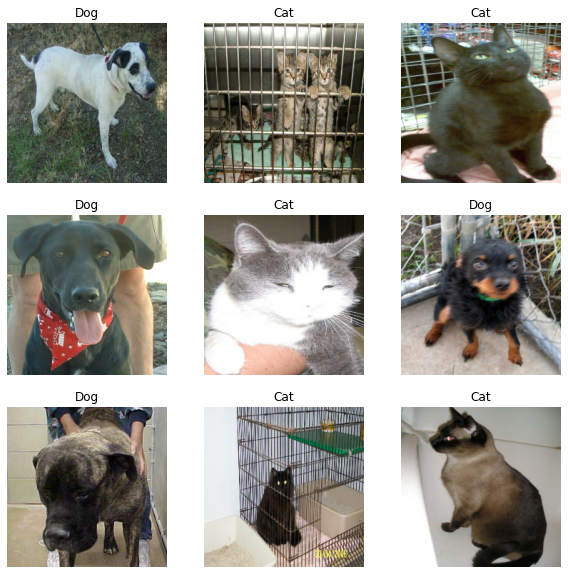

In [11]:

class_names = ds_train.class_names
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Modelos pré-treinados

Para muitos desafios de classificação de imagens é possível encontrar modelos de redes neurais já treinados. Muitos desses modelos estão disponíveis na ```keras.applications``` e outros modelos podem ser achados na internet. Para esse desafio será utilizado o VGG16, seguindo a indicação da descrição inicial do desafio.


## VGG16

Como explicado anteriormente, antes das imagens serem usados no modelo de rede neural pré-treinado, é necessário pré-processar as imagens para deixá-las adequadas ao modelo (range entre 0 e 1, por exemplo). Por isso foi utilizado a função `preprocess_input`, que recebe as imagens cruas e devolve as imagens processadas, que nesse caso gira em torno de 1000 elementos tensores, representando probabilidade para cada classe, onde também é possível descobrir qual a maior probabilidade do número da classe, por isso foi usado o `argmax`

Ao obter o resultado, teremos número de uma classe do ImageNet. Para fazer sentido o resultado, é possível usar o `decode_predictions`, que retorna top n classes juntas com seus nomes.

In [12]:
vgg = keras.applications.VGG16()
inp = keras.applications.vgg16.preprocess_input(x_sample[:1])

res = vgg(inp)
print(f"Most probable class = {tf.argmax(res,1)}")

keras.applications.vgg16.decode_predictions(res.numpy())

553467096/553467096 [==============================] - 6s 0us/step
Most probable class = [208]
35363/35363 [==============================] - 0s 0us/step


[[('n02099712', 'Labrador_retriever', 0.5340949),
  ('n02100236', 'German_short-haired_pointer', 0.09394425),
  ('n02092339', 'Weimaraner', 0.081605464),
  ('n02099849', 'Chesapeake_Bay_retriever', 0.057179626),
  ('n02109047', 'Great_Dane', 0.037338514)]]

Vamos verificar a arquitetura do VGG16:

In [13]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

O conjunto de dados ImageNet contém imagens de tamanho fixo de 224x224 e canais RGB. Portanto, temos um tensor de (224, 224, 3) como nossa entrada. Este modelo processa a imagem de entrada e produz um vetor de 1000 valores.

Segundo artigo publicado no GeekForGeeks, a leitura para a arquitetura do VGG segue o fluxo abaixo:

Observando a arquitetura acima, é possível perceber que a entrada para a rede é uma imagem com as dimensões (224, 224, 3). Já as primeiras duas camadas têm 64 canais de tamanho de filtro 3x3 e mesmo preenchimento. Em seguida, após uma camada de pool máxima de passada (2, 2) , duas camadas que têm camadas de convolução de tamanho de filtro de 256 e tamanho de filtro (3, 3) . Isso é seguido por uma camada máxima de acúmulo de passada (2, 2), que é a mesma da camada anterior. Então, existem 2 camadas de convolução de tamanho de filtro (3, 3) e filtro de 256 . Depois disso, existem 2 conjuntos de 3 camadas de convolução e uma camada de pool máximo. Cada um tem 512 filtros de (3, 3) tamanho com o mesmo preenchimento. Esta imagem é então passada para a pilha de duas camadas de convolução. Nessas camadas de convolução e pooling máximo, os filtros que usamos são do tamanho 3x3. Em algumas das camadas, ele também usa 1x1 pixel, que é usado para manipular o número de canais de entrada. Há um preenchimento de 1 pixel (mesmo preenchimento) feito após cada camada de convolução para evitar o recurso espacial da imagem.

Após a pilha de convolução e camada de pooling máximo, temos um mapa de feições (7, 7, 512). Nós nivelamos essa saída para torná-la um vetor de recurso (1, 25088) . Depois disso, há 3 camadas totalmente conectadas, a primeira camada obtém a entrada do último vetor de recurso e produz um vetor (1, 4096) , a segunda camada também produz um vetor de tamanho (1, 4096), mas a terceira camada de saída de 1000 canais para 1000 classes de desafio ILSVRC, então, após a saída da 3ª camada totalmente conectada, é passada para a camada softmax a fim de normalizar o vetor de classificação. Após a saída do vetor de classificação temos 5 categorias principais para avaliação. Todas as camadas ocultas usam ReLU como sua função de ativação. O ReLU (Rectified Linear Unit - Unidade Linear Unificada) é mais eficiente computacionalmente porque resulta em um aprendizado mais rápido e também diminui a probabilidade de problema de gradiente de desaparecimento.

### Extraindo features do VGG16

Para extrair variáveis resultantes do processamento das imagens pelo VGG16, é preciso utiliar o modelo sem as layers finais de classificação:

58889256/58889256 [==============================] - 0s 0us/step
Shape after applying VGG-16: (7, 7, 512)


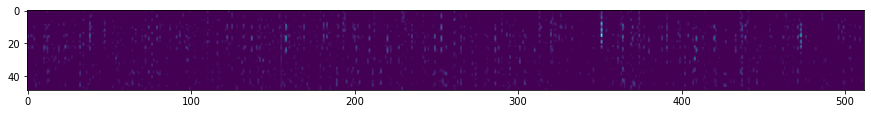

In [14]:
vgg = keras.applications.VGG16(include_top=False)

inp = keras.applications.vgg16.preprocess_input(x_sample[:1])
res = vgg(inp)
print(f"Shape after applying VGG-16: {res[0].shape}")
plt.figure(figsize=(15,3))
plt.imshow(res[0].numpy().reshape(-1,512))

É possível ver que a dimensão do tensor é 512x7x7, porém é preciso redimensioar para um formato 2D. 

Vamos tentar usar essas variáveis para classificar as imagens. Inicialmente vamos usar uma parte das imagens (40 minibaches para esse caso) e pre-compucaremos suas variáveis. 

A ideia é que usemos o Tensorflow dataset API para fazer isso. A função ```.map``` pega o dataset e aplica, com uma função lambda para transformá-lo. Podemos usar esse mecanismo para construir novos datasets: ```ds_features_train``` para armazenar as features de treino e ```ds_features_test``` para armazenar as features de teste, no lugar das imagens originais.

In [15]:
num = batch_size*40
ds_features_train = ds_train.take(40).map(lambda x,y : (vgg(x),y))
ds_features_test = ds_test.take(8).map(lambda x,y : (vgg(x),y))

for x,y in ds_features_train:
    print(x.shape,y.shape)
    break

(64, 7, 7, 512) (64,)


Agora que temos o dataset com as variáveis extraídas, podemos treinar um simples classificador para distinguir cachorros de gatos. Essa rede neural irá pegar vetores de tamanho (7, 7, 512) e nos entregará como resultado a correspondência para cachorro ou gato, visto que se trata de uma classificação binária.

In [16]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,7,512)),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_features_train, validation_data=ds_features_test)

40/40 [==============================] - 1461s 37s/step - loss: 1.9235 - acc: 0.8957 - val_loss: 0.6134 - val_acc: 0.9512


Temos um resultado ótimo até aqui, com um modelo que acerta cerca de 95% (vale lembrar que foram usados somente uma amostra do dataset para treino e teste).

## Transfer learning usando a rede neural VGG

Anteriormente as features foram pre-computadas de forma manual. Para evitar esse trabalho, é possível utilizar a rede neural VGG16 em sua forma original. Como estamos falando de redes neurais, a arquitetura Keras permite que o modelo definido anteriormente possa ser utilizado para uma nova rede neural.

In [17]:
model = keras.models.Sequential()
model.add(keras.applications.VGG16(include_top=False,input_shape=(224,224,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1,activation='sigmoid'))

model.layers[0].trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


É possível ver que a rede neural possui:

- feature extractor (features), composta por um número de camadas de convulação e pool;

- final classifier, que consiste em várias camadas densas, que transforma 25088 variáveis de input em 1000 classes (que é o número de classes no ImageNet);

Sabendo disso, para construir um modelo end-to-end que irá classificar nosso dataset, é necessário:

- Ajudar o final classifier para imprimir somente o número de classes que queremos. No nosso caso, manteremos o input de 25088 features, mas ajustaremos o output para 2 neurônios.

- Manter fixo os valores usados no feature extractor, já que eles não estão treinados. É preciso fazer isso para que ele não destrua o modelo pré-treinado.

Testando o novo modelo

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(ds_train, validation_data=ds_test)

É visível que foi conseguido um aumento razoável da acurácia do modelo.